In [67]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

In [68]:
def normalize_series(country_series, world_mean, world_std, categories):
    """
    Normalizes the values of a country's series with respect to the world mean and standard deviation.

    :param country_series: pandas Series containing the country's data.
    :param world_mean: pandas Series containing the world's mean for each category.
    :param world_std: pandas Series containing the world's standard deviation for each category.
    :return: A dictionary containing normalized values for each category.
    """

    normalized_data = {}

    for category in categories:
        if category == "agriculture":
            # Adding 1 to both country and world mean as per original calculation
            normalized_value = ((country_series[category] + 1) - (world_mean[category] + 1)) / world_std[category]
        else:
            normalized_value = (country_series[category] - world_mean[category]) / world_std[category]

        normalized_data[category] = normalized_value

    return normalized_data

In [69]:
def draw_arrow(ax1, x1, ax2, x2, y1=0.5, y2=0.5, arrowstyle="->", connectionstyle="arc3", color="black", linewidth=2,
               mutation_scale=20):
    """
    Draw an arrow between two circles located on different axes.
    
    Parameters:
    ax1: The source axes object.
    x1: The x-coordinate of the circle in the source axes.
    ax2: The destination axes object.
    x2: The x-coordinate of the circle in the destination axes.
    y1: The y-coordinate of the circle in the source axes.
    y2: The y-coordinate of the circle in the destination axes.
    arrowstyle: The style of the arrow.
    connectionstyle: The style of the connection between the two axes.
    color: The color of the arrow.
    linewidth: The width of the arrow line.
    mutation_scale: The size of the arrow head.
    """
    # Starting point in ax1
    xyA = (x1, y1)

    # Ending point in ax2
    xyB = (x2, y2)

    # Create a ConnectionPatch arrow
    arrow = patches.ConnectionPatch(
        xyA=xyA,
        xyB=xyB,
        coordsA=ax1.transData,
        coordsB=ax2.transData,
        arrowstyle=arrowstyle,
        connectionstyle=connectionstyle,
        mutation_scale=mutation_scale,
        linewidth=linewidth,
        color=color
    )

    # Add the arrow to the figure
    ax1.figure.patches.append(arrow)

In [70]:
all_in_one = pd.read_csv('../data/all_in_one.csv', index_col=0)
all_in_one_no_inf = all_in_one.replace([np.inf, -np.inf], np.nan)
wdi_outcomes = pd.read_csv('../data/wdi_outcomes.csv')
wdi_outcomes_no_inf = wdi_outcomes.replace([np.inf, -np.inf], np.nan)

In [71]:
canada_2014 = all_in_one_no_inf.loc[
    (all_in_one_no_inf['Country.Name'] == 'Canada') & (all_in_one_no_inf['Year'] == 2014)].iloc[0]
canada_2014_outcomes = wdi_outcomes_no_inf.loc[
    (wdi_outcomes_no_inf['Country.Name'] == 'Canada') & (wdi_outcomes_no_inf['Year'] == 2014)].iloc[0]

In [72]:
all_countries_2014 = all_in_one_no_inf.loc[
    (all_in_one_no_inf['Year'] == 2014)]
all_countries_2014_outcomes = wdi_outcomes_no_inf.loc[
    (wdi_outcomes_no_inf['Year'] == 2014)]
world_2014_mean = all_countries_2014.select_dtypes(include=[np.number]).mean()
world_2014_mean_outcomes = all_countries_2014_outcomes.select_dtypes(include=[np.number]).mean()
world_2014_std = all_countries_2014.select_dtypes(include=[np.number]).std()
world_2014_std_outcomes = all_countries_2014_outcomes.select_dtypes(include=[np.number]).std()

In [73]:
def reject_outliers(sr, iq_range=0.8):
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1 - pcnt])
    iqr = qhigh - qlow
    return sr[(sr - median).abs() <= iqr]

In [74]:
all_countries_2014_energy_no_outliers = reject_outliers(all_countries_2014["energy"])
world_2014_mean_energy = pd.Series()
world_2014_mean_energy["energy"] = all_countries_2014_energy_no_outliers.mean()
world_2014_std_energy = pd.Series()
world_2014_std_energy["energy"] = all_countries_2014_energy_no_outliers.std()

In [75]:
normalized_canada_2014 = normalize_series(canada_2014, world_2014_mean, world_2014_std,
                                          ["agriculture", "industry", "services", "grosscapital"])
normalized_canada_2014_outcomes = normalize_series(canada_2014_outcomes, world_2014_mean_outcomes,
                                                   world_2014_std_outcomes, ["lifeexpectancy", "schoolenr"])
normalized_canada_2014_energy = normalize_series(canada_2014, world_2014_mean_energy, world_2014_std_energy, ["energy"])

In [81]:
agriculture, industry, services, grosscapital = normalized_canada_2014.values()
lifeexpectancy, education = normalized_canada_2014_outcomes.values()
energy = normalized_canada_2014_energy["energy"]

In [82]:
# Arrays to define the structure (update as needed)
all_x_coords = [[0.125, 0.375, 0.625, 0.875], [0.125, 0.375, 0.625, 0.875], [0.25, 0.5, 0.75],
                [0.125, 0.375, 0.625, 0.875],
                [0.125, 0.375, 0.625, 0.875]
                ]
all_x_axis_ticks = [['Worker', 'Capital', 'Energy', 'Resource'], ['State', 'Market', 'Household', 'Commons'],
                    ['Agriculture', 'Industry', 'Services'], ['Core', 'Foundational', 'Overlooked', 'Competitive'],
                    ['Accumulation', 'Needs', 'HDI', 'Waste']
                    ]
all_y_axis_ticks = [['extraction'], ['realms'], ['industry'], ['foundational'], ['dissipation']]
all_sizes = [[0.1, 0.1, energy, 0.1], [0.1, 0.1, 0.1, 0.1], [agriculture, industry, services], [0.1, 0.1, 0.1, 0.1],
             [grosscapital, lifeexpectancy, education, 0.1]]

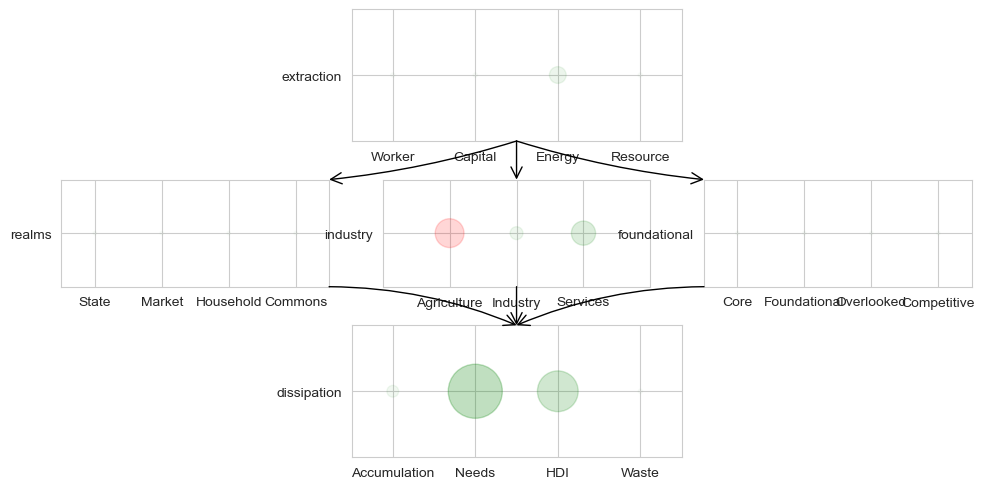

In [83]:
# Create a figure with a defined gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(3, 1)

# Creating the first and the third main subplot
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[2, 0])

# Creating a nested gridspec for the second main subplot
gs_nested = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1])

# Creating the three smaller subplots within the second main subplot
ax3 = plt.subplot(gs_nested[0])
ax4 = plt.subplot(gs_nested[1])
ax5 = plt.subplot(gs_nested[2])

# List of all axes
all_axes = [ax1, ax3, ax4, ax5, ax2]  # Reordered to match the structure

# Plotting loop
for ax in all_axes:
    index = all_axes.index(ax)
    x_coords = all_x_coords[index]
    x_axis_ticks = all_x_axis_ticks[index]
    y_axis_ticks = all_y_axis_ticks[index]
    sizes = all_sizes[index]
    for x, size, color in zip(x_coords, sizes, x_axis_ticks):
        if size < 0:
            color = 'red'
        else:
            color = 'green'
        circle = plt.Circle((x, 0.5), radius=abs(size) / 15, color=color, alpha=abs(size) / 5)
        ax.set_ylim(0.3, 0.7)
        ax.add_patch(circle)
        ax.set_aspect('equal', 'box')
        ax.set_xticks(x_coords)
        ax.set_xticklabels(x_axis_ticks)
        ax.set_yticks([0.5])
        ax.set_yticklabels(y_axis_ticks)

draw_arrow(ax1, 0.5, ax4, 0.5, linewidth=1, y1=0.3, y2=0.7)
draw_arrow(ax1, 0.5, ax5, 0, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=0.05")
draw_arrow(ax1, 0.5, ax3, 1, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=-0.05")

draw_arrow(ax3, 1, ax2, 0.5, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=-0.1")
draw_arrow(ax5, 0, ax2, 0.5, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=0.1")
draw_arrow(ax4, 0.5, ax2, 0.5, linewidth=1, y1=0.3, y2=0.7)

plt.tight_layout()
plt.show()